In [65]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 


#Some code to beautify the plots
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

from testproblems import gravity, blur

In [73]:
n = 256
A, b, xtrue = gravity(n, example = 0)

sigma = 0.05*np.linalg.norm(b, np.inf)
noise = sigma*np.random.randn(b.size) 
bn = b + noise
print "Noise to signal ratio", np.linalg.norm(noise)/np.linalg.norm(b)

Noise to signal ratio 0.07506040681255946


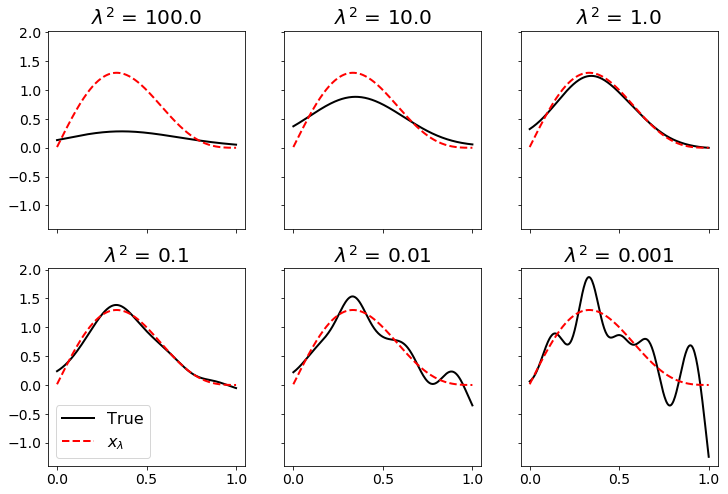

In [67]:
l2lst = [1e2,1e1,1e0,1e-1,1e-2,1e-3]

u,s,vh = np.linalg.svd(A)

t = np.linspace(0,1,n)
f, axarray = plt.subplots(2,3, sharex = True, sharey = True, figsize = (12,8))
for i, ax in enumerate(axarray.flatten()):
    l = l2lst[i]
    sl = np.diag(s/(l+s**2.)); D = np.diag(sl)
    xk = np.dot(vh.T,np.dot(np.diag(D),np.dot(u.T,bn)))
    
    ax.plot(t, xk, 'k-', t, xtrue, 'r--', linewidth = 2.0)
    ax.set_title('$\lambda^2$ = ' + str(l), fontsize = 20)
    
    if i == 3: ax.legend({ '$x_\lambda$', 'True'}, fontsize = 16)

### Discrepancy principle

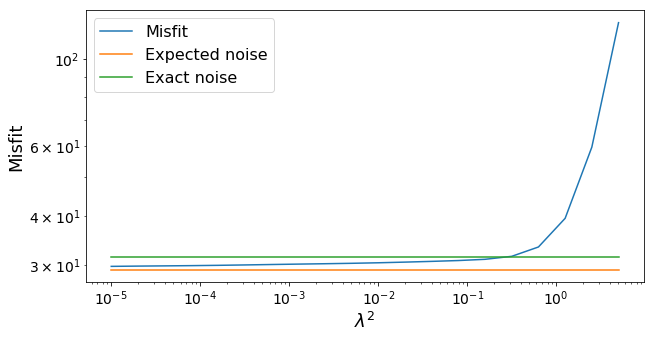

In [108]:
l2lst = 10.**np.arange(-5,1,0.3)
misfit = 0*l2lst
u,s,vh = np.linalg.svd(A)
for j, l in enumerate(l2lst):
    
    sl = np.diag(s/(l+s**2.)); D = np.diag(sl)
    xk = np.dot(vh.T,np.dot(np.diag(D),np.dot(u.T,bn)))
    
    misfit[j] = np.linalg.norm(np.dot(A,xk) - bn)**2
    
plt.loglog(l2lst, misfit)

nsig = n*sigma**2.
plt.loglog(l2lst,nsig*np.ones_like(l2lst))
nnrm = np.linalg.norm(noise)**2.
plt.loglog(l2lst,nnrm*np.ones_like(l2lst))
plt.xlabel('$\lambda^2$', fontsize = 18)
plt.ylabel('Misfit', fontsize = 18)
plt.legend({'Misfit', 'Expected noise', 'Exact noise'}, fontsize = 16)

### L-curve 

Text(0.5,1,'Illustration of L-curve')

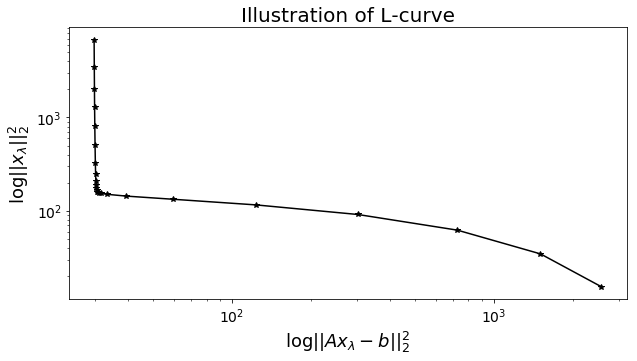

In [100]:
l2lst = 10.**np.arange(-5,2,0.3)
u,s,vh = np.linalg.svd(A)

misfit = 0*l2lst
reg    = 0*l2lst

c      = 0*l2lst

for j,l in enumerate(l2lst):
    
    sl = np.diag(s/(l+s**2.)); D = np.diag(sl)
    xk = np.dot(vh.T,np.dot(np.diag(D),np.dot(u.T,bn)))
    
    rk = np.dot(A,xk) - bn
    rho = np.linalg.norm(rk)**2
    xi  = np.linalg.norm(xk)**2
    
    #Compute the curvature
    zk = np.dot(vh.T,np.dot(np.diag(D),np.dot(u.T,rk)))
    xip = 4*np.inner(xk,zk)/np.sqrt(l)
    c[j] = 2*(xi*rho/xip)*(l*xip*rho+2*np.sqrt(l)*xi*rho + l**2.*xi*xip)/(l*xi**2.+rho**2.)**1.5
    
    
    misfit[j] = rho
    reg[j]    = xi

plt.loglog(misfit, reg, 'k-*')
plt.xlabel('$\log ||Ax_\lambda -b||_2^2$', fontsize = 18)
plt.ylabel('$\log||x_\lambda||_2^2$', fontsize = 18)
plt.title('Illustration of L-curve', fontsize = 20)


The point on the L-curve with the maximum curvature is often taken to be the "optimal" regularization parameter.

### Generalized cross validation

 The location of the minimizer is $\lambda_{gcv}^2$ [0.02115174]


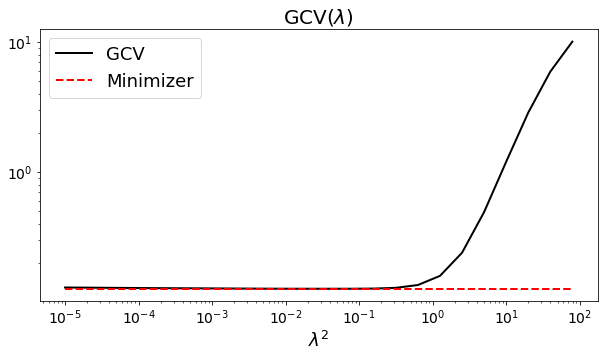

In [105]:
l2lst = 10.**np.arange(-5,2,0.3)
u,s,vh = np.linalg.svd(A)
gcv = 0*l2lst

for j,l in enumerate(l2lst):
    
    sl = np.diag(s/(l+s**2.)); D = np.diag(sl)
    xk = np.dot(vh.T,np.dot(np.diag(D),np.dot(u.T,bn)))
    
    rk = np.dot(A,xk) - bn
    rho = np.linalg.norm(rk)**2
    
    phi = np.diag(s**2./(l+s**2.))
    df = n - np.sum(phi)
    
    gcv[j] = n*rho/(df**2.)


    
# Minimize GCV interpolant
from scipy.interpolate import interp1d
from scipy.optimize import minimize
f = interp1d(l2lst,gcv)
res = minimize(f,0.1)
plt.loglog(l2lst, gcv, 'k-',label = 'GCV',linewidth = 2.0)
plt.loglog(l2lst, res['fun']*np.ones_like(l2lst), 'r--', label = 'Minimizer', linewidth = 2.0)
plt.xlabel('$\lambda^2$', fontsize = 18)
plt.title('GCV($\lambda$)', fontsize = 20)
plt.legend( fontsize = 18)

print "The location of the minimizer is $\lambda_{gcv}^2$", res['x']

## Unbiased predictive risk estimator

Text(0.5,1,'UPRE($\\lambda$)')

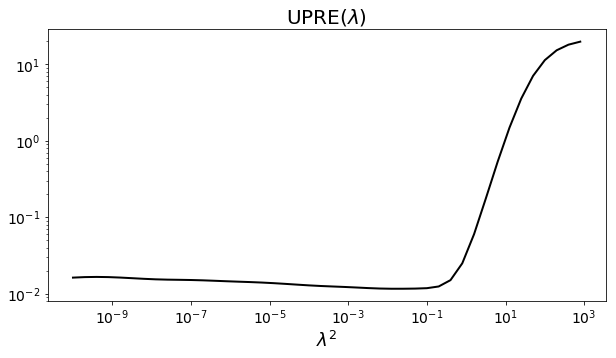

In [103]:
l2lst = 10.**np.arange(-10,3,0.3)
u,s,vh = np.linalg.svd(A)
upre = 0*l2lst

for j,l in enumerate(l2lst):
    
    sl = np.diag(s/(l+s**2.)); D = np.diag(sl)
    xk = np.dot(vh.T,np.dot(np.diag(D),np.dot(u.T,bn)))
    
    rk = np.dot(A,xk) - bn
    rho = np.linalg.norm(rk)**2
    
    phi = np.diag(s**2./(l+s**2.))
    upre[j] = rho/n + 2*sigma**2.*np.sum(phi)/n - sigma**2.


# Minimize UPRE interpolant
plt.loglog(l2lst, upre, 'k-',label = 'UPRE',linewidth = 2.0)
plt.xlabel('$\lambda^2$', fontsize = 18)
plt.title('UPRE($\lambda$)', fontsize = 20)